# Chapter 3 - Deep Q-learning
### Deep Reinforcement Learning *in Action*

##### Listing 3.1

In [1]:
from Gridworld import Gridworld
# size: 정사각형의 한 변의 길이
# mode; static: 정적모드, player: 플레이어 위치 무작위, random: 모든 객체 무작위 
game = Gridworld(size=4, mode='static')

In [2]:
# display(): 게임판 출력
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
# u: up, d: down, l:left, r: right
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
# makemove() 후 받는 보상 
# 승리: 10, 패배: -10, otherwise: -1
game.reward()

-1

In [5]:
# 순서대로 player, object tile, fail tile, wall
# 위치에 해당하면 1 나머지 값들은 모두 0 
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

##### Listing 3.2

In [6]:
# 신경망 생성 코드
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

##### Listing 3.3

In [7]:
# Q learning 에서는 수치만 다룰 수 있으므로 
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [9]:
epochs = 1000
losses = [] #A
for i in range(epochs): #B
    game = Gridworld(size=4, mode='static') # 새로운 게임을 만든다
    # 현재 상태에 약간의 noise 추가 
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #D
    state1 = torch.from_numpy(state_).float() #E
    status = 1 # 게임이 진행중인지 확인하기 위해 사용하는 변수 
    while(status == 1): # 게임이 진행중 이라면,
        qval = model(state1) # Q value를 예측한다 
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): # epsilon의 확률로 랜덤 move
            action_ = np.random.randint(0,4)
        else:  # 1-epsilon의 확률로 greedy 
            action_ = np.argmax(qval_)
        
        # action_ 은 숫자이므로 makemove()가 이해할 수 있는 문자로 변경 
        action = action_set[action_] 
        game.makeMove(action) # 그에 맞게 움직인다 
        # t+1에서의 state를 새로 얻는다 
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #L
        reward = game.reward()
        with torch.no_grad():  # 이 안에선 pytorch가 계산 그래프를 생성하지 않는다, 메모리 절약 
            newQ = model(state2.reshape(1,64))  # q value 새로 예측 
        maxQ = torch.max(newQ) # t+1에서의 Q value의 max값 
        if reward == -1: # reward가 -1이 아니면 게임이 끝났다는 뜻 
            # Y는 목표 Q value이다 
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        
        # detach()는 계산 그래프에서 노드를 떼어 냄
        # detach()를 하지 않았다면 loss_fn(X,Y)에서 두 변수 모두 역전파가 일어남 
        # 하지만 우린 X만 갱신하고 싶음 
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] #O
        loss = loss_fn(X, Y) #P
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: #Q
            status = 0
    if epsilon > 0.1: #R
        epsilon -= (1/epochs)

999 0.010927587747573853


Text(0, 0.5, 'Loss')

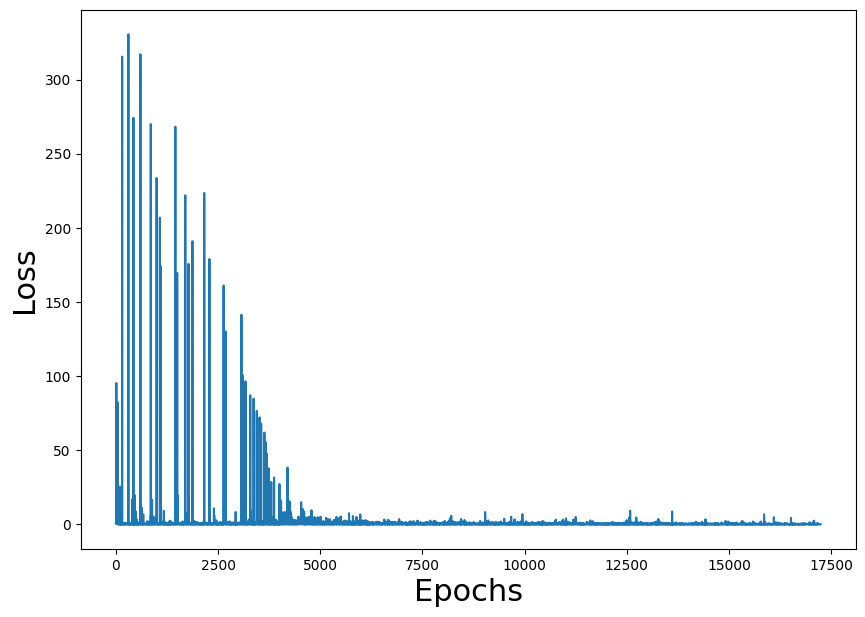

In [10]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

##### PyTorch Automatic Differentiation Review

In [11]:
# pytorch가 익숙하지 않을 수 있으므로 
# 간단한 선형 모델로 설명 
m = torch.Tensor([2.0])
m.requires_grad=True
b = torch.Tensor([1.0])
b.requires_grad=True
def linear_model(x,m,b):
    y = m + b#@ x + b
    return y

In [12]:
#with torch.no_grad():
y = linear_model(torch.Tensor([4]),m,b)

In [13]:
y.grad_fn

In [14]:
y.backward()

In [15]:
m.grad

tensor([1.])

##### Listing 3.4

In [16]:
# 손실계산과 역전파를 사용하지 않는 걸 제외하면 훈련모델과 거의 유사


def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [17]:
test_model(model)

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [18]:
# static에선 성공하지만 random에선 fail함을 알 수 있다. 
# 위의 훈련 코드에서 'random'으로 바꿔도 제대로 학습하지 못함
# 즉 해답을 암기했다고밖에 설명할 수 없음 
test_model(model, 'random')

Initial State:
[[' ' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' '+' ' ' ' ']]
Move #: 0; Taking action: l
[[' ' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' '+' ' ' ' ']]
Move #: 1; Taking action: l
[[' ' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' '+' ' ' ' ']]
Move #: 2; Taking action: l
[[' ' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' '+' ' ' ' ']]
Move #: 3; Taking action: u
[[' ' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' '+' ' ' ' ']]
Move #: 4; Taking action: u
[[' ' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' '+' ' ' ' ']]
Move #: 5; Taking action: u
[[' ' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' '+' ' ' ' ']]
Move #: 6; Taking action: u
[[' ' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' '+' ' ' ' ']]
Move #: 7; Taking action: u
[[' ' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' '+' ' ' ' ']]
Move #: 8; Taking action: u
[[' ' '-' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [

False

##### Listing 3.5

In [19]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [20]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 # experience replay list 길이 
batch_size = 200 # mini-batch 크기 
replay = deque(maxlen=mem_size) # deque를 experience replay list로 사용
max_moves = 50 # 50번 이상 움직일 경우 포기 
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0  # 움직인 수 체크 
    while(status == 1): 
        mov += 1
        qval = model(state1) #E
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #F
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)

        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) # 한 경험을 튜플로 묶기
        replay.append(exp) # 기억에 추가 
        state1 = state2
        
        if len(replay) > batch_size: # 어느정도 기억이 모이면, 
            minibatch = random.sample(replay, batch_size) # mini-batch 사이즈만큼 뽑자
            # state 배치는 ([batch_size],64), 
            # 다른 변수들은 ([batch_size},)이므로 다르게 다룬다 
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L
            # Q2는 기울기를 계산할 필요가 없으므로 
            with torch.no_grad():
                Q2 = model(state2_batch) 
            
            # 게임이 끝났다면 done=1이므로 Y=reward 꼴이 된다 
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            # 해당 action에 대한 index를 사용해서 q 예측값을 가져온다 
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)

#A Set the total size of the experience replay memory
#B Set the minibatch size
#C Create the memory replay as a deque list
#D Maximum number of moves before game is over
#E Compute Q-values from input state in order to select action
#F Select action using epsilon-greedy strategy
#G Create experience of state, reward, action and next state as a tuple
#H Add experience to experience replay list
#I If replay list is at least as long as minibatch size, begin minibatch training
#J Randomly sample a subset of the replay list
#K Separate out the components of each experience into separate minibatch tensors
#L Re-compute Q-values for minibatch of states to get gradients
#M Compute Q-values for minibatch of next states but don't compute gradients
#N Compute the target Q-values we want the DQN to learn
#O If game is over, reset status and mov number

4999 0.06003301590681076


In [21]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

Text(0, 0.5, 'Loss')

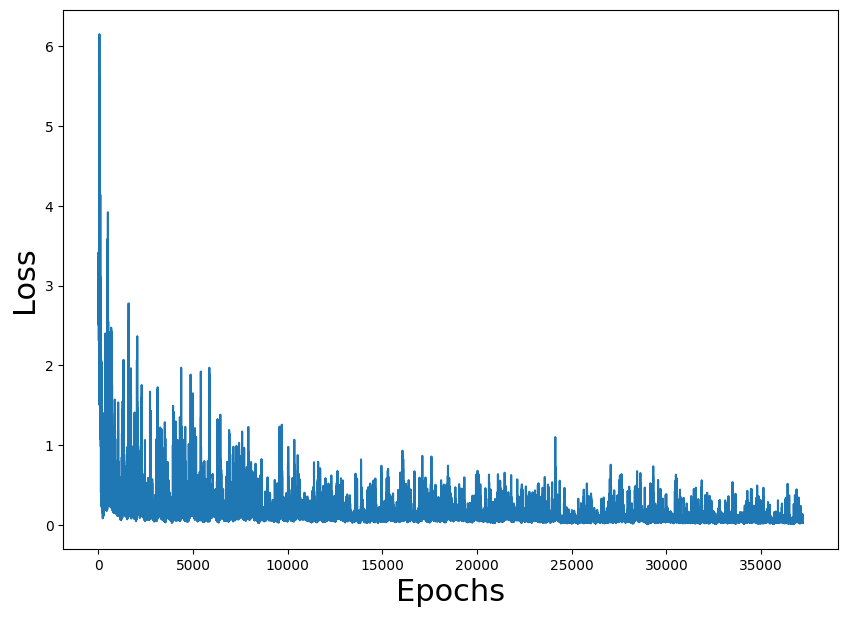

In [22]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [23]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 887
Win percentage: 88.7%


In [24]:
test_model(model, mode='random')

Initial State:
[[' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' 'P' '+']]
Move #: 0; Taking action: r
[[' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]
Game won! Reward: 10


True

###### Listing 3.7

In [25]:
# target net 을 이용하자 
import copy

l1 = 64
l2 = 150
l3 = 100
l4 = 4


model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)

model2 = copy.deepcopy(model) # target net 
model2.load_state_dict(model.state_dict()) # copy parameters

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [26]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500 # 갱신할 주기 
j=0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        j+=1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: # target net을 Q-net에 복사 
                model2.load_state_dict(model.state_dict())
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)

#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network

4999 0.05498882383108139


Text(0, 0.5, 'Loss')

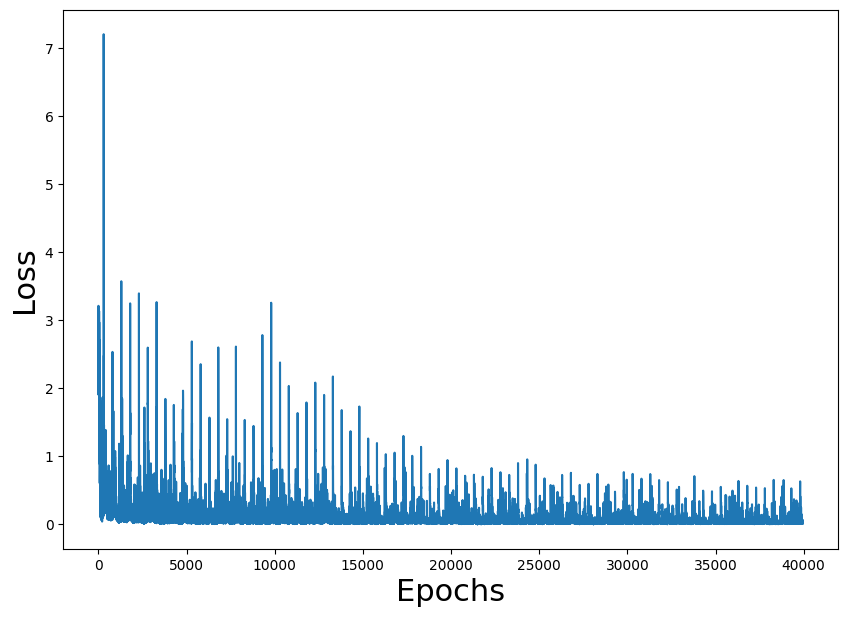

In [27]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [28]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 919
Win percentage: 91.9%
